In [ ]:
%load_ext autoreload
%autoreload 2
exec(open('init_notebook.py').read())
from matplotlib import pyplot as plt
from highD.HighD import HighD
from highD.Filter import Filter
from highD.Plot import Plot
from highD.Visualizer import GIF
from highD.helper import *

In [ ]:
ids = [str(i).zfill(2) for i in range(1, 2)]
highD = HighD(ids, DATA_DIRECTORY)

In [ ]:
# Retrieve combined dataframes and images
dfs = highD.get_combined_dataframes()
images = highD.get_images()

# Initialize an empty list to store resulting dataframes
follow_meta_data = []

# Iterate over all dataframes
for idx, df in enumerate(dfs):
    # Filter dataframe for vehicle follow scenarios
    filtered_df = Filter.filter_vehicle_follow_scenario(df, 
                                                        ego_type='Car', 
                                                        preceding_type='Car',
                                                        minDuration=5, 
                                                        minStartDistance=50,
                                                        maxStartDistance=100,
                                                        removeStrictDistanceInc=True)
    
    # Add dataset_id column
    # filtered_df['dataset_id'] = ids[idx]
    filtered_df.insert(0, 'dataset_id', ids[idx])
    
    # Append filtered dataframe to the list
    follow_meta_data.append(filtered_df)

# Combine all filtered dataframes into one
follow_meta_df = pd.concat(follow_meta_data)

print(follow_meta_df.shape)
follow_meta_df.head()

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

scenario_id = 0
print(follow_meta_df.iloc[scenario_id])
ego_df, prec_df = get_scenario_data(dfs, follow_meta_df, scenario_id)

ego_vel = ego_df['xVelocity'].values
prec_vel = prec_df['xVelocity'].values
dx = ego_df['x'].values - prec_df['x'].values
dx = np.abs(dx)

In [ ]:
FPS = 25
T = 1/FPS

# ALL Parameter

In [ ]:

# Defining the functions
def idm_all_param(input, desired_vel, max_acc, comf_dec, min_distance, safe_thw, delta):
    ego_vel, prec_vel, dx = input
    s_star = min_distance + desired_vel * safe_thw + desired_vel * (ego_vel - prec_vel) / (2 * np.sqrt(max_acc * comf_dec))
    cur_acc = max_acc * (1 - np.power(ego_vel / desired_vel, delta) - np.power(s_star / dx, 2))
    return cur_acc

def idm_all_param_test(input, desired_vel, max_acc, comf_dec, min_distance, safe_thw, delta):
    ego_vel, prec_vel, dx = input
    cur_acc = idm_all_param(input, desired_vel, max_acc, comf_dec, min_distance, safe_thw, delta)
    return ego_vel[:-1] + cur_acc[:-1] * T

# Calculate bounds and initial guess
positive_acceleration = ego_df[ego_df['xAcceleration'] > 0]['xAcceleration'].values
negative_acceleration = ego_df[ego_df['xAcceleration'] < 0]['xAcceleration'].values

bounds = [
    [min(ego_vel), min(positive_acceleration) if positive_acceleration.size else 1e-6, 
     min(negative_acceleration) if negative_acceleration.size else 1e-6, 1e-9, 0, 1],
    [max(ego_vel), max(positive_acceleration) if positive_acceleration.size else 3, 
     max(negative_acceleration) if negative_acceleration.size else 2, min(dx), 1.5, 6]
]

initial_guess = [(b[0] + (b[1] - b[0]) / 2) for b in zip(bounds[0], bounds[1])]

print(f'Bounds: {bounds}, Initial Guess: {initial_guess}')
# f_out = ego_df['xAcceleration'].values
f_out = ego_df['xVelocity'].values
f_out = f_out[1:]


# Curve fit
popt, pcov = curve_fit(idm_all_param_test, (ego_vel, prec_vel, dx), f_out, p0=initial_guess)
popt_dict = dict(zip(['desired_vel', 'max_acc', 'comf_dec', 'min_distance', 'safe_thw', 'delta'], popt))
print(popt_dict)

residuals = f_out - idm_all_param_test((ego_vel, prec_vel, dx), *popt)
rmse = np.sqrt(mean_squared_error(f_out, idm_all_param_test((ego_vel, prec_vel, dx), *popt)))
print(f'Root Mean Squared Error: {rmse}')

# Covariance heatmap
sns.heatmap(pcov, annot=True, cmap='coolwarm')
plt.title('Covariance Matrix Heatmap')
plt.show()

# Calculate fitted values
y_acc = idm_all_param((ego_vel, prec_vel, dx), *popt)
y_vel = idm_all_param_test((ego_vel, prec_vel, dx), *popt)

# Create plots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(ego_df['xAcceleration'].values, label='acceleration')
axs[0].plot(y_acc, label='fitted acceleration')
axs[1].plot(ego_vel, label='ego_vel')
axs[1].plot(y_vel, label='fitted velocity')

# Configure plots
for ax in axs:
    ax.legend()
    ax.set_xlabel('Time')

axs[0].set_title('Acceleration and Fitted Acceleration')
axs[0].set_ylabel('Acceleration')
axs[1].set_title


# Distance and THW

In [ ]:
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract necessary values
desired_vel = ego_df['xVelocity'].max()
max_acc = max(ego_df['xAcceleration'].max(), 1e-6)
comf_dec = min(ego_df['xAcceleration'].min(), 1e-6)
delta = 4

print(f'desired_vel: {desired_vel}, max_acc: {max_acc}, comf_dec: {comf_dec}')

min_dis, max_dis = 1e-9, min(dx)
min_thw, max_thw = 0e-9, 1.5

bounds = [[min_dis, min_thw],
         [max_dis, max_thw]]
initial_guess = [(min_dis + (max_dis-min_dis)/2), (min_thw + (max_thw-min_thw)/2)]

print(bounds, initial_guess)

# Define IDM functions
def idm_common(input, min_distance, safe_thw):
    ego_vel, prec_vel, dx = input
    time_headway_product = desired_vel * safe_thw
    velocity_difference_product = desired_vel * (ego_vel - prec_vel)
    acceleration_product = 2 * np.sqrt(max_acc * comf_dec)
    s_star = min_distance + time_headway_product + velocity_difference_product / acceleration_product
    return np.power(s_star / dx, 2), np.power(ego_vel / desired_vel, delta)

def idm_distance_thw(input, min_distance, safe_thw):
    dec, acc = idm_common(input, min_distance, safe_thw)
    return max_acc * (1 - acc - dec)

def idm_distance_thw_test(input, min_distance, safe_thw):
    ego_vel, _, _ = input
    dec, acc = idm_common(input, min_distance, safe_thw)
    cur_acc = max_acc * (1 - acc - dec)
    return ego_vel[:-1] + cur_acc[:-1] * T

# Fitting
f_out = ego_vel[1:]
# f_out = ego_df['xAcceleration'].values


popt, pcov = curve_fit(idm_distance_thw_test, (ego_vel, prec_vel, dx), f_out, p0= initial_guess, bounds=bounds)
popt_dict = dict(zip(['min_distance', 'safe_thw'], popt))
print(popt_dict)

residuals = f_out - idm_distance_thw_test((ego_vel, prec_vel, dx), *popt)
rmse = np.sqrt(mean_squared_error(f_out, idm_distance_thw_test((ego_vel, prec_vel, dx), *popt)))
print(f'Root Mean Squared Error: {rmse}')


# Plotting
sns.heatmap(pcov, annot=True, cmap='coolwarm')
plt.title('Covariance Matrix Heatmap')
plt.show()

y_acc = idm_distance_thw((ego_vel, prec_vel, dx), *popt)
y_vel = idm_distance_thw_test((ego_vel, prec_vel, dx), *popt)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(f_out, label='acceleration')
axs[0].plot(y_acc, label='fitted acceleration')
axs[1].plot(ego_vel, label='ego_vel')
axs[1].plot(y_vel, label='fitted velocity')

for ax in axs:
    ax.legend()
    ax.set_xlabel('Time')
axs[0].set_title('Acceleration and Fitted Acceleration')
axs[0].set_ylabel('Acceleration')
axs[1].set_title('Velocity and Fitted Velocity')
axs[1].set_ylabel('Velocity')

plt.tight_layout()
plt.show()


# Desired Vel, Min_distance, THW

max_acc: 0.38, comf_dec: 1e-06
[[40.28, 1e-09, 0.0], [41.91, 50.77999999999997, 1.5]] [41.095, 25.390000000499988, 0.75]
{'desired_vel': 8.441875387764673, 'min_distance': 42091.79044126088, 'safe_thw': -6014.633209667877}
Root Mean Squared Error: 570.3324980171811


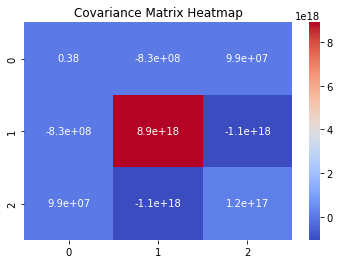

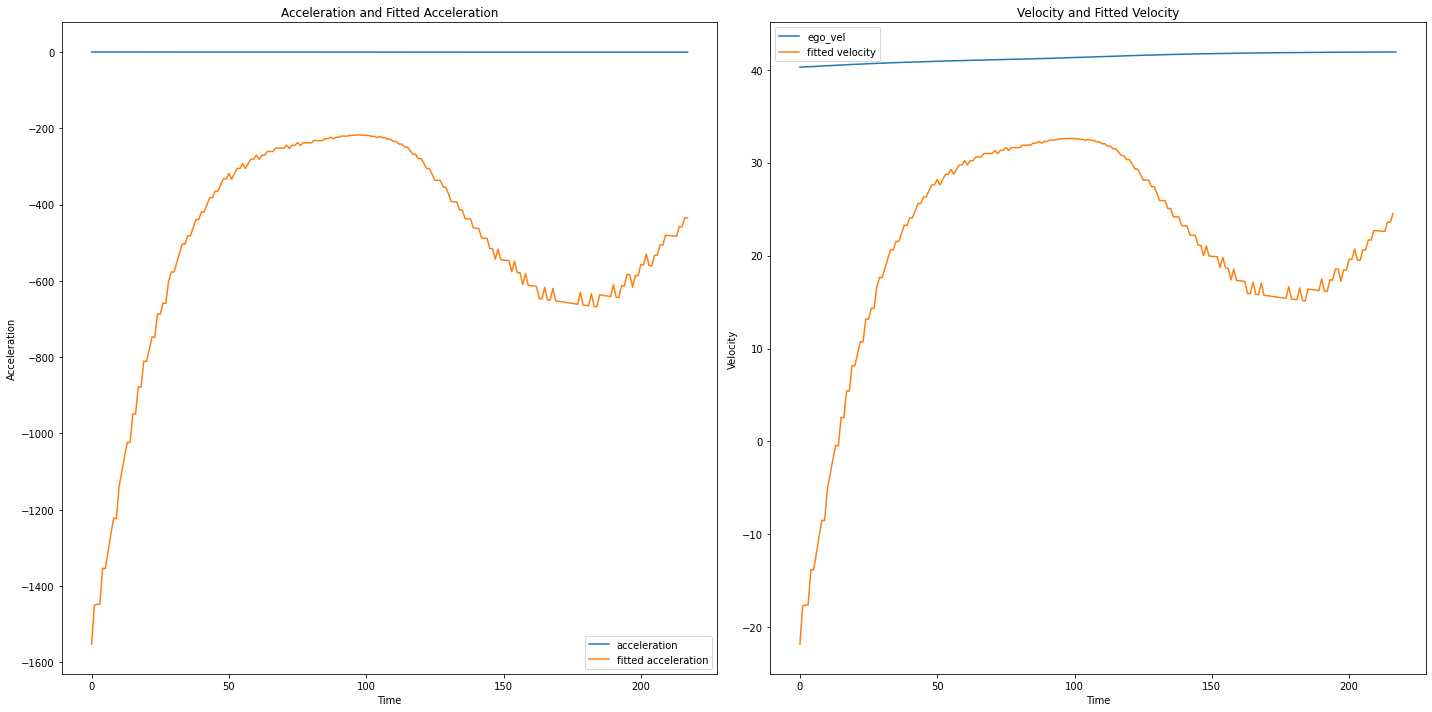

In [53]:
# Calculate bounds and initial guess
positive_acceleration = ego_df[ego_df['xAcceleration'] > 0]['xAcceleration'].values
negative_acceleration = ego_df[ego_df['xAcceleration'] < 0]['xAcceleration'].values

max_acc = max(max(positive_acceleration), 1e-6)
if len(negative_acceleration) != 0:
    comf_dec = min(min(negative_acceleration), 1e-6)
else:
    comf_dec = 1e-6
delta = 4

print(f'max_acc: {max_acc}, comf_dec: {comf_dec}')

min_vel, max_vel = min(ego_vel), max(ego_vel)
min_dis, max_dis = 1e-9, min(dx)
min_thw, max_thw = 0e-9, 1.5

bounds = [[min_vel, min_dis, min_thw],
         [max_vel, max_dis, max_thw]]
initial_guess = [(min_vel + (max_vel-min_vel)/2),
                 (min_dis + (max_dis-min_dis)/2), 
                 (min_thw + (max_thw-min_thw)/2)]

print(bounds, initial_guess)

# Define IDM functions
def idm_common(input, desired_vel, min_distance, safe_thw):
    ego_vel, prec_vel, dx = input
    time_headway_product = desired_vel * safe_thw
    velocity_difference_product = desired_vel * (ego_vel - prec_vel)
    acceleration_product = 2 * np.sqrt(max_acc * comf_dec)
    s_star = min_distance + time_headway_product + velocity_difference_product / acceleration_product
    return np.power(s_star / dx, 2), np.power(ego_vel / desired_vel, delta)

def idm_distance_thw(input, desired_vel, min_distance, safe_thw):
    dec, acc = idm_common(input, desired_vel, min_distance, safe_thw)
    return max_acc * (1 - acc - dec)

def idm_distance_thw_test(input, desired_vel, min_distance, safe_thw):
    ego_vel, _, _ = input
    dec, acc = idm_common(input, desired_vel, min_distance, safe_thw)
    cur_acc = max_acc * (1 - acc - dec)
    return ego_vel[:-1] + cur_acc[:-1] * T

# Fitting
# f_out = ego_vel[1:]
f_out = ego_df['xAcceleration'].values


popt, pcov = curve_fit(idm_distance_thw, (ego_vel, prec_vel, dx), f_out, p0= initial_guess)
popt_dict = dict(zip(['desired_vel', 'min_distance', 'safe_thw'], popt))
print(popt_dict)

residuals = f_out - idm_distance_thw((ego_vel, prec_vel, dx), *popt)
rmse = np.sqrt(mean_squared_error(f_out, idm_distance_thw((ego_vel, prec_vel, dx), *popt)))
print(f'Root Mean Squared Error: {rmse}')


# Plotting
sns.heatmap(pcov, annot=True, cmap='coolwarm')
plt.title('Covariance Matrix Heatmap')
plt.show()

y_acc = idm_distance_thw((ego_vel, prec_vel, dx), *popt)
y_vel = idm_distance_thw_test((ego_vel, prec_vel, dx), *popt)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(f_out, label='acceleration')
axs[0].plot(y_acc, label='fitted acceleration')
axs[1].plot(ego_vel, label='ego_vel')
axs[1].plot(y_vel, label='fitted velocity')

for ax in axs:
    ax.legend()
    ax.set_xlabel('Time')
axs[0].set_title('Acceleration and Fitted Acceleration')
axs[0].set_ylabel('Acceleration')
axs[1].set_title('Velocity and Fitted Velocity')
axs[1].set_ylabel('Velocity')

plt.tight_layout()
plt.show()
